In [1]:
import torch
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import time
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

from srgan import Generator, Discriminator, GeneratorLoss

import sys
sys.path.append('../')
from custom_image_dataset import CustomImageDataset
from image_helper import ImageHelper
from model_runner import ModelRunner

from SRCNN import SRCNN
sys.path.append('../DBPN/')
from DBPN_copied import DBPN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/SRGAN/../model_runner.py:308: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if model_name is "Bicubic":


In [2]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [4]:
# TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
# VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
TRAIN_DATASET_NAME = "../datasets/set14/"
VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 128 # 32 * 4
PATCHES_PER_IMAGE_TRAIN = 30 ##
PATCHES_PER_IMAGE_VALIDATION = 20 ##
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/set14/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/Set5/_128_128_number=20


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/set14/_128_128_number=30


100%|██████████| 14/14 [00:00<00:00, 93.05it/s]


Creating Dataset based on folder: ../datasets/set14/_128_128_number=30
Creating Dataset based on folder: ../datasets/Set5/_128_128_number=20


100%|██████████| 5/5 [00:00<00:00, 214.52it/s]

Creating Dataset based on folder: ../datasets/Set5/_128_128_number=20
Training set has 169 instances
Validation set has 30 instances
CPU times: user 7.98 s, sys: 370 ms, total: 8.35 s
Wall time: 782 ms


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**7))

num_workers = 0

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers)

CPU times: user 4.09 ms, sys: 31 µs, total: 4.12 ms
Wall time: 3.77 ms


In [8]:
netG = Generator(UPSCALE_FACTOR).to(device)
netD = Discriminator().to(device)
generator_criterion = GeneratorLoss().to(device)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [10]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

d_loss_array = []
g_loss_array = []
d_score_array = []
g_score_array = []


In [11]:
N_EPOCHS = 75 # 150 is good enough for our model. gives decent enough results

In [14]:
model_runner = ModelRunner()

# Lists to store training and validation losses
train_losses = []
val_losses = []
discriminator_losses = []
time_array = []
epoch_array = []
lr_array = []

# Initialize tqdm progress bar for the entire training process
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    epoch_array.append(epoch)
    lr_array.append(optimizerG.param_groups[0]['lr'])

    start_time = time.time()


    running_results = {'batch_sizes': 0, 'd_loss': 0,
                    "g_loss": 0, "d_score": 0, "g_score": 0}

    netG.train()
    netD.train()
    for data, target in train_dataloader:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        # Move real images and noise vectors to the device
        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        # Generate fake images using the generator
        fake_img = netG(z)
        # Zero out the gradients of the discriminator
        netD.zero_grad()

        # Compute the discriminator scores for real and fake images
        real_out = netD(real_img).mean()        
        fake_out = netD(fake_img).mean()

        # Calculate the discriminator loss
        d_loss = 1 - real_out + fake_out

        # Backpropagate the discriminator loss and update its parameters
        d_loss.backward(retain_graph = True)
        optimizerD.step()

        ## Now update Generator ##
        # Generate fake images again using the updated generator
        fake_img = netG(z)
        # Compute the discriminator score for the generated fake images
        fake_out = netD(fake_img).mean()

        # Zero out the gradients of the generator
        netG.zero_grad()

        # Calculate the generator loss using a predefined criterion
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        
        # Backpropagate the generator loss and update its parameters
        g_loss.backward()
        optimizerG.step()


        # Update the running results with batch-wise metrics
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size # TODO: check if this is correct (fake_out.item() * batch_size maybe?)


        ##### my code #####
        # g_loss_array.append(g_loss.item())
        # d_loss_array.append(d_loss.item())
        # d_score_array.append(real_out.item())
        # g_score_array.append(fake_out.item())
        ###################

    # Validation loop
    netG.eval()
    netD.eval()
    val_loss = 0

    # Iterate through each batch in the validation dataloader
    with torch.no_grad():
        for val_data, val_target in validation_dataloader:
            val_batch_size = val_data.size(0)
            real_img_val = Variable(val_target).to(device)
            z_val = Variable(val_data).to(device)

            fake_img_val = netG(z_val)
            fake_out_val = netD(fake_img_val).mean()

            # Calculate validation loss
            val_loss += generator_criterion(fake_out_val, fake_img_val, real_img_val).item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss
        val_losses.append(avg_val_loss)

    end_time = time.time() - start_time
    time_array.append(end_time)

    # Update the tqdm progress bar to show relevant information
    tqdm.write(
        "[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f Val Loss: %.4f Time: %.4f"
        % (
            epoch + 1, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes'],
            avg_val_loss,
            end_time
        ))
    
    # Store training loss for plotting
    train_losses.append(running_results['g_loss'] / running_results['batch_sizes'])

    discriminator_losses.append(running_results['d_loss'] / running_results['batch_sizes'])




Epochs:   0%|          | 0/75 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epochs:   1%|▏         | 1/75 [00:01<01:54,  1.55s/it]

[1/75] Loss_D: 0.9905 Loss_G: 0.0735 D(x): 0.4912 D(G(z)): 0.4341 Val Loss: 0.0937 Time: 1.5462


Epochs:   3%|▎         | 2/75 [00:02<01:14,  1.02s/it]

[2/75] Loss_D: 0.8863 Loss_G: 0.0516 D(x): 0.5316 D(G(z)): 0.3784 Val Loss: 0.0866 Time: 0.6432


Epochs:   4%|▍         | 3/75 [00:02<01:00,  1.18it/s]

[3/75] Loss_D: 0.8177 Loss_G: 0.0319 D(x): 0.5821 D(G(z)): 0.3582 Val Loss: 0.0682 Time: 0.6377


Epochs:   5%|▌         | 4/75 [00:03<00:54,  1.31it/s]

[4/75] Loss_D: 0.7644 Loss_G: 0.0278 D(x): 0.5909 D(G(z)): 0.3288 Val Loss: 0.0559 Time: 0.6423


Epochs:   7%|▋         | 5/75 [00:04<00:50,  1.39it/s]

[5/75] Loss_D: 0.6883 Loss_G: 0.0244 D(x): 0.6296 D(G(z)): 0.2867 Val Loss: 0.0555 Time: 0.6398


Epochs:   8%|▊         | 6/75 [00:04<00:47,  1.44it/s]

[6/75] Loss_D: 0.6649 Loss_G: 0.0213 D(x): 0.6895 D(G(z)): 0.2626 Val Loss: 0.0515 Time: 0.6358


Epochs:   9%|▉         | 7/75 [00:05<00:45,  1.48it/s]

[7/75] Loss_D: 0.5925 Loss_G: 0.0202 D(x): 0.6717 D(G(z)): 0.2454 Val Loss: 0.0442 Time: 0.6401


Epochs:  11%|█         | 8/75 [00:06<00:44,  1.51it/s]

[8/75] Loss_D: 0.5509 Loss_G: 0.0189 D(x): 0.7237 D(G(z)): 0.2310 Val Loss: 0.0387 Time: 0.6375


Epochs:  12%|█▏        | 9/75 [00:06<00:43,  1.52it/s]

[9/75] Loss_D: 0.5721 Loss_G: 0.0176 D(x): 0.7433 D(G(z)): 0.2182 Val Loss: 0.0327 Time: 0.6400


Epochs:  13%|█▎        | 10/75 [00:07<00:42,  1.53it/s]

[10/75] Loss_D: 0.5513 Loss_G: 0.0168 D(x): 0.7073 D(G(z)): 0.2534 Val Loss: 0.0246 Time: 0.6388


Epochs:  15%|█▍        | 11/75 [00:07<00:41,  1.54it/s]

[11/75] Loss_D: 0.5106 Loss_G: 0.0163 D(x): 0.7635 D(G(z)): 0.1996 Val Loss: 0.0189 Time: 0.6382


Epochs:  16%|█▌        | 12/75 [00:08<00:40,  1.55it/s]

[12/75] Loss_D: 0.5109 Loss_G: 0.0156 D(x): 0.7459 D(G(z)): 0.2917 Val Loss: 0.0176 Time: 0.6420


Epochs:  17%|█▋        | 13/75 [00:09<00:39,  1.55it/s]

[13/75] Loss_D: 0.5185 Loss_G: 0.0150 D(x): 0.7465 D(G(z)): 0.1640 Val Loss: 0.0169 Time: 0.6385


Epochs:  19%|█▊        | 14/75 [00:09<00:39,  1.55it/s]

[14/75] Loss_D: 0.4883 Loss_G: 0.0147 D(x): 0.8068 D(G(z)): 0.1994 Val Loss: 0.0140 Time: 0.6388


Epochs:  20%|██        | 15/75 [00:10<00:38,  1.55it/s]

[15/75] Loss_D: 0.4427 Loss_G: 0.0145 D(x): 0.7034 D(G(z)): 0.1523 Val Loss: 0.0122 Time: 0.6415


Epochs:  21%|██▏       | 16/75 [00:11<00:37,  1.56it/s]

[16/75] Loss_D: 0.4773 Loss_G: 0.0138 D(x): 0.8424 D(G(z)): 0.1963 Val Loss: 0.0119 Time: 0.6388


Epochs:  23%|██▎       | 17/75 [00:11<00:37,  1.55it/s]

[17/75] Loss_D: 0.3782 Loss_G: 0.0133 D(x): 0.7458 D(G(z)): 0.1077 Val Loss: 0.0116 Time: 0.6429


Epochs:  24%|██▍       | 18/75 [00:12<00:36,  1.55it/s]

[18/75] Loss_D: 0.2948 Loss_G: 0.0135 D(x): 0.8692 D(G(z)): 0.1484 Val Loss: 0.0106 Time: 0.6414


Epochs:  25%|██▌       | 19/75 [00:13<00:36,  1.55it/s]

[19/75] Loss_D: 0.2343 Loss_G: 0.0128 D(x): 0.8914 D(G(z)): 0.1063 Val Loss: 0.0104 Time: 0.6417


Epochs:  27%|██▋       | 20/75 [00:13<00:35,  1.56it/s]

[20/75] Loss_D: 0.2361 Loss_G: 0.0129 D(x): 0.8763 D(G(z)): 0.0906 Val Loss: 0.0106 Time: 0.6381


Epochs:  28%|██▊       | 21/75 [00:14<00:34,  1.55it/s]

[21/75] Loss_D: 0.1888 Loss_G: 0.0127 D(x): 0.9108 D(G(z)): 0.0805 Val Loss: 0.0103 Time: 0.6436


Epochs:  29%|██▉       | 22/75 [00:15<00:34,  1.56it/s]

[22/75] Loss_D: 0.1462 Loss_G: 0.0124 D(x): 0.9196 D(G(z)): 0.0549 Val Loss: 0.0098 Time: 0.6399


Epochs:  31%|███       | 23/75 [00:15<00:33,  1.56it/s]

[23/75] Loss_D: 0.1454 Loss_G: 0.0119 D(x): 0.9072 D(G(z)): 0.0484 Val Loss: 0.0099 Time: 0.6397


Epochs:  32%|███▏      | 24/75 [00:16<00:32,  1.56it/s]

[24/75] Loss_D: 0.1085 Loss_G: 0.0123 D(x): 0.9404 D(G(z)): 0.0491 Val Loss: 0.0092 Time: 0.6417


Epochs:  33%|███▎      | 25/75 [00:16<00:32,  1.55it/s]

[25/75] Loss_D: 0.1127 Loss_G: 0.0125 D(x): 0.9569 D(G(z)): 0.0442 Val Loss: 0.0088 Time: 0.6481


Epochs:  35%|███▍      | 26/75 [00:17<00:31,  1.55it/s]

[26/75] Loss_D: 0.0851 Loss_G: 0.0114 D(x): 0.9529 D(G(z)): 0.0307 Val Loss: 0.0093 Time: 0.6426


Epochs:  36%|███▌      | 27/75 [00:18<00:30,  1.55it/s]

[27/75] Loss_D: 0.0769 Loss_G: 0.0115 D(x): 0.9647 D(G(z)): 0.0396 Val Loss: 0.0092 Time: 0.6413


Epochs:  37%|███▋      | 28/75 [00:18<00:30,  1.55it/s]

[28/75] Loss_D: 0.0718 Loss_G: 0.0112 D(x): 0.9554 D(G(z)): 0.0298 Val Loss: 0.0088 Time: 0.6410


Epochs:  39%|███▊      | 29/75 [00:19<00:29,  1.56it/s]

[29/75] Loss_D: 0.0858 Loss_G: 0.0111 D(x): 0.9749 D(G(z)): 0.0318 Val Loss: 0.0103 Time: 0.6398


Epochs:  40%|████      | 30/75 [00:20<00:28,  1.55it/s]

[30/75] Loss_D: 0.0482 Loss_G: 0.0110 D(x): 0.9783 D(G(z)): 0.0277 Val Loss: 0.0086 Time: 0.6421


Epochs:  41%|████▏     | 31/75 [00:20<00:28,  1.55it/s]

[31/75] Loss_D: 0.0963 Loss_G: 0.0119 D(x): 0.9307 D(G(z)): 0.0398 Val Loss: 0.0080 Time: 0.6419


Epochs:  43%|████▎     | 32/75 [00:21<00:27,  1.55it/s]

[32/75] Loss_D: 0.1500 Loss_G: 0.0111 D(x): 0.9801 D(G(z)): 0.0182 Val Loss: 0.0079 Time: 0.6420


Epochs:  44%|████▍     | 33/75 [00:22<00:27,  1.55it/s]

[33/75] Loss_D: 0.1056 Loss_G: 0.0107 D(x): 0.9180 D(G(z)): 0.0272 Val Loss: 0.0076 Time: 0.6473


Epochs:  45%|████▌     | 34/75 [00:22<00:26,  1.55it/s]

[34/75] Loss_D: 0.1195 Loss_G: 0.0105 D(x): 0.9801 D(G(z)): 0.0385 Val Loss: 0.0093 Time: 0.6426


Epochs:  47%|████▋     | 35/75 [00:23<00:25,  1.55it/s]

[35/75] Loss_D: 0.1931 Loss_G: 0.0105 D(x): 0.8203 D(G(z)): 0.0165 Val Loss: 0.0085 Time: 0.6398


Epochs:  48%|████▊     | 36/75 [00:24<00:25,  1.55it/s]

[36/75] Loss_D: 0.1550 Loss_G: 0.0099 D(x): 0.9806 D(G(z)): 0.3537 Val Loss: 0.0079 Time: 0.6460


Epochs:  49%|████▉     | 37/75 [00:24<00:24,  1.55it/s]

[37/75] Loss_D: 0.2737 Loss_G: 0.0110 D(x): 0.9342 D(G(z)): 0.0466 Val Loss: 0.0085 Time: 0.6424


Epochs:  51%|█████     | 38/75 [00:25<00:23,  1.55it/s]

[38/75] Loss_D: 0.3357 Loss_G: 0.0107 D(x): 0.7012 D(G(z)): 0.0546 Val Loss: 0.0080 Time: 0.6434


Epochs:  52%|█████▏    | 39/75 [00:25<00:23,  1.55it/s]

[39/75] Loss_D: 0.1792 Loss_G: 0.0102 D(x): 0.9697 D(G(z)): 0.2126 Val Loss: 0.0070 Time: 0.6457


Epochs:  53%|█████▎    | 40/75 [00:26<00:22,  1.55it/s]

[40/75] Loss_D: 0.2098 Loss_G: 0.0099 D(x): 0.9733 D(G(z)): 0.1158 Val Loss: 0.0070 Time: 0.6435


Epochs:  55%|█████▍    | 41/75 [00:27<00:21,  1.55it/s]

[41/75] Loss_D: 0.1643 Loss_G: 0.0099 D(x): 0.9072 D(G(z)): 0.0425 Val Loss: 0.0071 Time: 0.6429


Epochs:  56%|█████▌    | 42/75 [00:27<00:21,  1.55it/s]

[42/75] Loss_D: 0.1053 Loss_G: 0.0098 D(x): 0.9630 D(G(z)): 0.0980 Val Loss: 0.0071 Time: 0.6413


Epochs:  57%|█████▋    | 43/75 [00:28<00:20,  1.55it/s]

[43/75] Loss_D: 0.0950 Loss_G: 0.0097 D(x): 0.9680 D(G(z)): 0.0236 Val Loss: 0.0077 Time: 0.6400


Epochs:  59%|█████▊    | 44/75 [00:29<00:19,  1.55it/s]

[44/75] Loss_D: 0.0952 Loss_G: 0.0100 D(x): 0.9212 D(G(z)): 0.0115 Val Loss: 0.0069 Time: 0.6428


Epochs:  60%|██████    | 45/75 [00:29<00:19,  1.55it/s]

[45/75] Loss_D: 0.0782 Loss_G: 0.0098 D(x): 0.9331 D(G(z)): 0.0144 Val Loss: 0.0082 Time: 0.6446


Epochs:  61%|██████▏   | 46/75 [00:30<00:18,  1.55it/s]

[46/75] Loss_D: 0.0520 Loss_G: 0.0101 D(x): 0.9760 D(G(z)): 0.0379 Val Loss: 0.0069 Time: 0.6453


Epochs:  63%|██████▎   | 47/75 [00:31<00:18,  1.55it/s]

[47/75] Loss_D: 0.0542 Loss_G: 0.0094 D(x): 0.9848 D(G(z)): 0.0300 Val Loss: 0.0072 Time: 0.6450


Epochs:  64%|██████▍   | 48/75 [00:31<00:17,  1.55it/s]

[48/75] Loss_D: 0.0373 Loss_G: 0.0094 D(x): 0.9847 D(G(z)): 0.0153 Val Loss: 0.0068 Time: 0.6423


Epochs:  65%|██████▌   | 49/75 [00:32<00:16,  1.55it/s]

[49/75] Loss_D: 0.0301 Loss_G: 0.0093 D(x): 0.9824 D(G(z)): 0.0093 Val Loss: 0.0066 Time: 0.6426


Epochs:  67%|██████▋   | 50/75 [00:33<00:16,  1.55it/s]

[50/75] Loss_D: 0.0222 Loss_G: 0.0092 D(x): 0.9849 D(G(z)): 0.0064 Val Loss: 0.0065 Time: 0.6446


Epochs:  68%|██████▊   | 51/75 [00:33<00:15,  1.55it/s]

[51/75] Loss_D: 0.0215 Loss_G: 0.0091 D(x): 0.9846 D(G(z)): 0.0063 Val Loss: 0.0066 Time: 0.6459


Epochs:  69%|██████▉   | 52/75 [00:34<00:14,  1.55it/s]

[52/75] Loss_D: 0.0153 Loss_G: 0.0091 D(x): 0.9914 D(G(z)): 0.0073 Val Loss: 0.0065 Time: 0.6432


Epochs:  71%|███████   | 53/75 [00:35<00:14,  1.55it/s]

[53/75] Loss_D: 0.0154 Loss_G: 0.0098 D(x): 0.9925 D(G(z)): 0.0081 Val Loss: 0.0065 Time: 0.6461


Epochs:  72%|███████▏  | 54/75 [00:35<00:13,  1.55it/s]

[54/75] Loss_D: 0.0135 Loss_G: 0.0092 D(x): 0.9948 D(G(z)): 0.0083 Val Loss: 0.0066 Time: 0.6450


Epochs:  73%|███████▎  | 55/75 [00:36<00:12,  1.55it/s]

[55/75] Loss_D: 0.0142 Loss_G: 0.0097 D(x): 0.9956 D(G(z)): 0.0088 Val Loss: 0.0071 Time: 0.6428


Epochs:  75%|███████▍  | 56/75 [00:36<00:12,  1.55it/s]

[56/75] Loss_D: 0.0104 Loss_G: 0.0091 D(x): 0.9964 D(G(z)): 0.0058 Val Loss: 0.0078 Time: 0.6421


Epochs:  76%|███████▌  | 57/75 [00:37<00:11,  1.55it/s]

[57/75] Loss_D: 0.0079 Loss_G: 0.0090 D(x): 0.9972 D(G(z)): 0.0046 Val Loss: 0.0063 Time: 0.6422


Epochs:  77%|███████▋  | 58/75 [00:38<00:10,  1.55it/s]

[58/75] Loss_D: 0.0067 Loss_G: 0.0093 D(x): 0.9975 D(G(z)): 0.0039 Val Loss: 0.0069 Time: 0.6451


Epochs:  79%|███████▊  | 59/75 [00:38<00:10,  1.55it/s]

[59/75] Loss_D: 0.0059 Loss_G: 0.0090 D(x): 0.9977 D(G(z)): 0.0034 Val Loss: 0.0067 Time: 0.6460


Epochs:  80%|████████  | 60/75 [00:39<00:09,  1.55it/s]

[60/75] Loss_D: 0.0064 Loss_G: 0.0090 D(x): 0.9975 D(G(z)): 0.0037 Val Loss: 0.0067 Time: 0.6464


Epochs:  81%|████████▏ | 61/75 [00:40<00:09,  1.55it/s]

[61/75] Loss_D: 0.0068 Loss_G: 0.0096 D(x): 0.9976 D(G(z)): 0.0039 Val Loss: 0.0063 Time: 0.6458


Epochs:  83%|████████▎ | 62/75 [00:40<00:08,  1.54it/s]

[62/75] Loss_D: 0.0054 Loss_G: 0.0094 D(x): 0.9977 D(G(z)): 0.0029 Val Loss: 0.0070 Time: 0.6485


Epochs:  84%|████████▍ | 63/75 [00:41<00:07,  1.54it/s]

[63/75] Loss_D: 0.0048 Loss_G: 0.0088 D(x): 0.9979 D(G(z)): 0.0026 Val Loss: 0.0066 Time: 0.6512


Epochs:  85%|████████▌ | 64/75 [00:42<00:07,  1.54it/s]

[64/75] Loss_D: 0.0046 Loss_G: 0.0091 D(x): 0.9979 D(G(z)): 0.0025 Val Loss: 0.0065 Time: 0.6469


Epochs:  87%|████████▋ | 65/75 [00:42<00:06,  1.54it/s]

[65/75] Loss_D: 0.0043 Loss_G: 0.0086 D(x): 0.9979 D(G(z)): 0.0021 Val Loss: 0.0072 Time: 0.6456


Epochs:  88%|████████▊ | 66/75 [00:43<00:05,  1.54it/s]

[66/75] Loss_D: 0.0045 Loss_G: 0.0089 D(x): 0.9978 D(G(z)): 0.0022 Val Loss: 0.0060 Time: 0.6452


Epochs:  89%|████████▉ | 67/75 [00:44<00:05,  1.54it/s]

[67/75] Loss_D: 0.0046 Loss_G: 0.0087 D(x): 0.9978 D(G(z)): 0.0024 Val Loss: 0.0078 Time: 0.6477


Epochs:  91%|█████████ | 68/75 [00:44<00:04,  1.54it/s]

[68/75] Loss_D: 0.0050 Loss_G: 0.0093 D(x): 0.9972 D(G(z)): 0.0021 Val Loss: 0.0070 Time: 0.6469


Epochs:  92%|█████████▏| 69/75 [00:45<00:03,  1.54it/s]

[69/75] Loss_D: 0.0038 Loss_G: 0.0090 D(x): 0.9982 D(G(z)): 0.0020 Val Loss: 0.0071 Time: 0.6471


Epochs:  93%|█████████▎| 70/75 [00:46<00:03,  1.54it/s]

[70/75] Loss_D: 0.0035 Loss_G: 0.0090 D(x): 0.9984 D(G(z)): 0.0019 Val Loss: 0.0073 Time: 0.6451


Epochs:  95%|█████████▍| 71/75 [00:46<00:02,  1.54it/s]

[71/75] Loss_D: 0.0038 Loss_G: 0.0088 D(x): 0.9984 D(G(z)): 0.0022 Val Loss: 0.0062 Time: 0.6460


Epochs:  96%|█████████▌| 72/75 [00:47<00:01,  1.54it/s]

[72/75] Loss_D: 0.0035 Loss_G: 0.0086 D(x): 0.9985 D(G(z)): 0.0019 Val Loss: 0.0069 Time: 0.6460


Epochs:  97%|█████████▋| 73/75 [00:47<00:01,  1.54it/s]

[73/75] Loss_D: 0.0035 Loss_G: 0.0097 D(x): 0.9985 D(G(z)): 0.0020 Val Loss: 0.0080 Time: 0.6457


Epochs:  99%|█████████▊| 74/75 [00:48<00:00,  1.54it/s]

[74/75] Loss_D: 0.0030 Loss_G: 0.0088 D(x): 0.9987 D(G(z)): 0.0016 Val Loss: 0.0072 Time: 0.6458


Epochs: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]

[75/75] Loss_D: 0.0037 Loss_G: 0.0086 D(x): 0.9982 D(G(z)): 0.0019 Val Loss: 0.0064 Time: 0.6468


In [22]:
df = model_runner.create_model_df(epoch_array, time_array, lr_array, train_losses, val_losses,
                            extra_columns={"discriminator_losses": discriminator_losses}        
)
df

,epoch,time,lr,train_loss,validation_loss,discriminator_losses
0,0,1.546156,0.0002,0.073523,0.093702,0.990502
1,1,0.643156,0.0002,0.051605,0.086649,0.886308
2,2,0.637700,0.0002,0.031931,0.068202,0.817741
3,3,0.642260,0.0002,0.027787,0.055886,0.764443
4,4,0.639771,0.0002,0.024439,0.055545,0.688252
...,...,...,...,...,...,...
70,70,0.646050,0.0002,0.008812,0.006186,0.003836
71,71,0.645951,0.0002,0.008650,0.006867,0.003470
72,72,0.645676,0.0002,0.009674,0.007989,0.003483
73,73,0.645777,0.0002,0.008750,0.007187,0.002996


In [23]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training


should_upsample MUST ONLY BE `TRUE` for SRCNN
tensor.shape = torch.Size([1, 3, 256, 256])


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


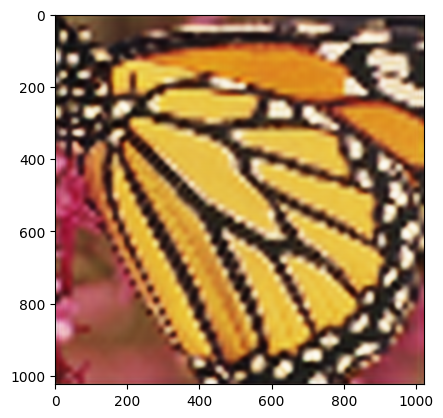

In [24]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)

In [25]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:01, 70.61it/s]
100it [00:01, 95.28it/s]


,PSNR,SSIM
SRGAN,23.382309,0.560957
Bicubic,23.045410,0.632868


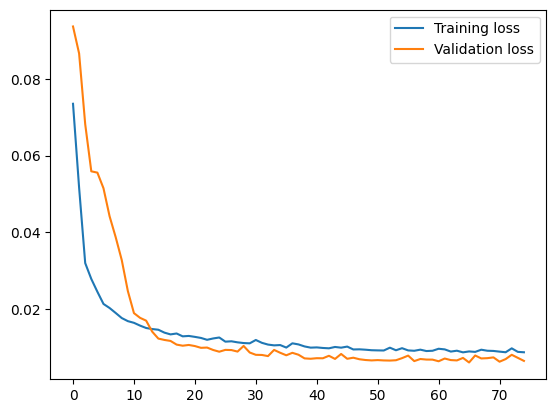

In [26]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()


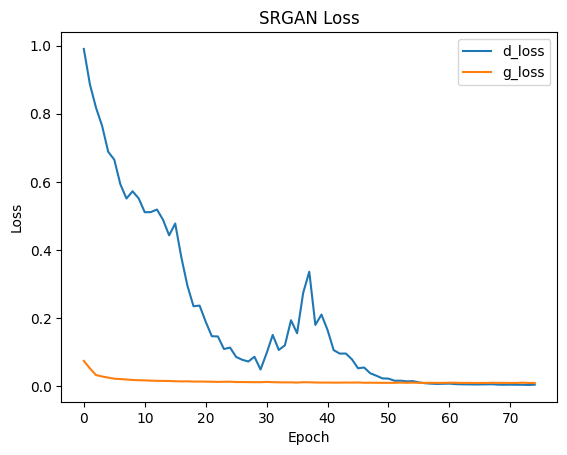

In [27]:
import matplotlib.pyplot as plt
# plot array
plt.plot(discriminator_losses, label='d_loss')
plt.plot(train_losses, label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SRGAN Loss')
plt.legend()
plt.show()


In [29]:
model_runner.save_model_df("srgan_netG_follwing_paper_df.csv", df_to_save=df)

In [ ]:
model_runner.save_model_weights(netG, '../results/srgan/trained_models/srgan_netG-following-article-150-epochs.pth')
model_runner.save_model_weights(netD, '../results/srgan/trained_models/srgan_netD-following-article-150-epochs.pth')

In [ ]:
netG_test = Generator(UPSCALE_FACTOR).to('cpu')
netG_test.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG-following-article-150-epochs.pth',  map_location=torch.device('cpu')))


<All keys matched successfully>

should_upsample MUST ONLY BE `TRUE` for SRCNN
tensor.shape = torch.Size([1, 3, 64, 64])


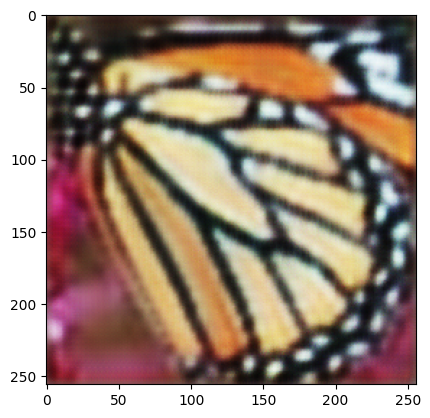

In [35]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG_test.to('cpu'),
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False,
    device='cpu'
)

In [19]:
model_runner = ModelRunner(device='cpu')
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:09, 10.86it/s]
100it [00:01, 56.42it/s]


,PSNR,SSIM
SRGAN,24.347925,0.667682
Bicubic,23.045410,0.632869


In [27]:
model_f2_5 = SRCNN(f2=5).to(device)
model_f2_5.load_state_dict(torch.load('../results/srcnn/trained_models/model_f2_5.pth', map_location=torch.device('cpu')))

model_without_noise = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_without_noise.load_state_dict(torch.load('./trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth', map_location=torch.device('cpu')))


FileNotFoundError: [Errno 2] No such file or directory: './trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth'

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

tensor.shape = torch.Size([3, 344, 228])
tensor.shape = torch.Size([1, 3, 86, 57])


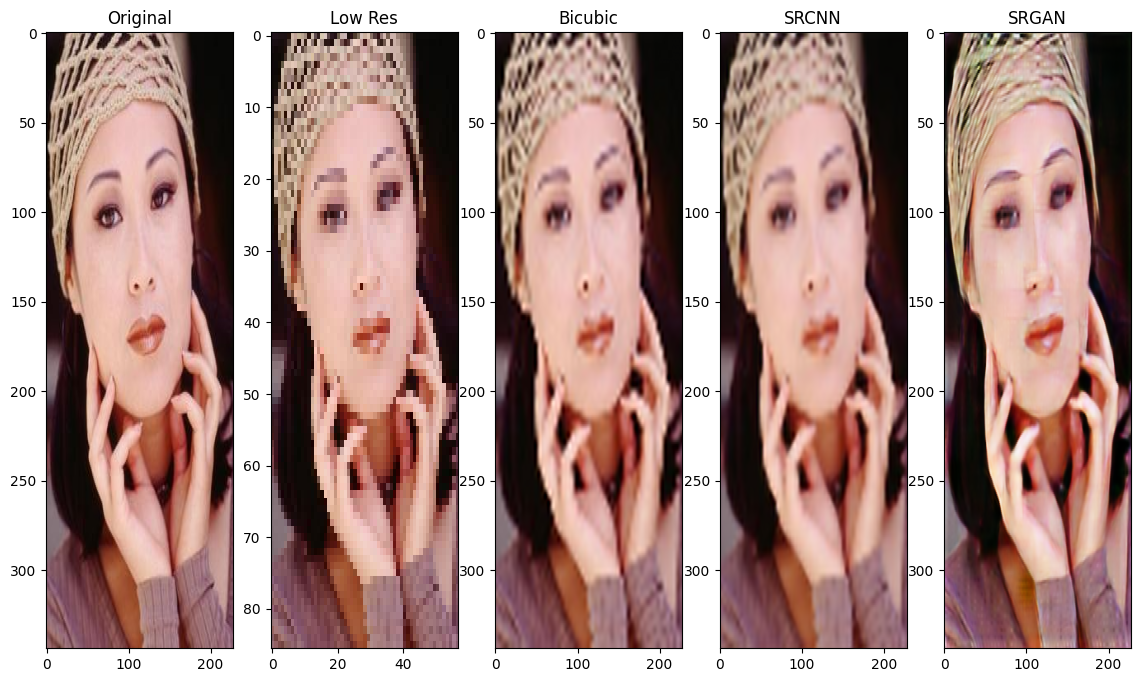

In [28]:
IMAGE_EXAMPLE = f"../datasets/Set5/woman.png"

image_helper.show_tensor_as_images_side_by_side(
    [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN",
            "tensor": image_helper.apply_model_to_image(
                model_f2_5,
                IMAGE_EXAMPLE,
                4
            )
        },
        {
            "label": "SRGAN",
            "tensor": image_helper.apply_model_to_image(
                netG_test.to('cpu'),
                IMAGE_EXAMPLE,
                downsample_factor=4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=test_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v4 (triangular)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v5 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v6 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=even_more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN *",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_epochs_less_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
    ],
)

In [30]:
model_runner.compare_models(
    [
        {
            "name": "SRCNN",
            "model": model_f2_5,
        },
        {"name": "DBPN without noise", "model": model_without_noise,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

100it [00:04, 24.49it/s]
100it [01:23,  1.19it/s]
100it [00:07, 13.97it/s]
100it [00:01, 70.65it/s]


,PSNR,SSIM
SRCNN,23.475697,0.630280
DBPN without noise,9.236373,0.055450
SRGAN,24.347925,0.667682
Bicubic,23.045410,0.632869
